## Building the graph

### Clipping: All except colabs mentioning "javascript" & "python"

After getting and parsing the data, we need to understand and create metrics that could lead us to our hypothesis and it's impacts.

In [99]:
from netpixi.integration.gt import Graph
import pandas as pd
import numpy as np

g = Graph(directed=False)

In [100]:
data = pd.read_csv("../data/colaboration_comments.csv")

In [101]:
# Add the source repositories (usually belonging to organizations where users collaborate)
data['source'] = list(map(lambda x : x.split("https://github.com/")[-1].split('/')[0],data['URL']))

In [102]:
#All except colabs mentioning "javascript" & "python"
data = data[data['BODY'].notna() & ~data['BODY'].str.lower().apply(lambda x: 'javascript' in str(x).lower() or 'js' in str(x).lower())]
data = data[data['BODY'].notna() & ~data['BODY'].str.lower().apply(lambda x: 'python' in str(x).lower() or 'py' in str(x).lower())]

In [103]:
# Drop columns which we won't use
data = data.drop(['COMMIT_ID','COMMENT_ID','URL'],axis=1)

In [104]:
#First view of data
data

,AUTHOR,CREATED_AT,BODY,source
0,zindlerb,2015-01-01T00:00:08Z,:sparkles: :pray: :sparkles:,selfhub
1,msabramo,2015-01-01T00:00:53Z,> Can you remove this empty line?\r\n\r\nDone.,tsuru
2,myclamm,2015-01-01T00:00:55Z,Thanks man. That's from week 4 of Hack Reactor...,GoldenLions
3,zindlerb,2015-01-01T00:01:44Z,"_.reduce would be more elegant, but your call",selfhub
4,rwjblue,2015-01-01T00:01:54Z,Tiny nit-pick: can you name this something mea...,emberjs
...,...,...,...,...
635297,rings360,2015-02-28T09:59:16Z,Asar Sunny <ring2rings93@gmail.com>,AGV-IIT-KGP
635298,jeffcarp,2015-02-28T09:59:16Z,Thank you for doing this! Would you mind if I ...,veswill3
635299,msabramo,2015-02-28T09:59:42Z,Done.,Robpol86
635300,msabramo,2015-02-28T09:59:52Z,Done.,Robpol86


In [105]:
#Looking to the total contribuitions for the users in the source repositories
total_contributions = data.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
total_contributions

AUTHOR
houndci       25534
nrel-bot       2968
bors-servo     2089
miabot         1782
bors           1443
              ...  
andkirby          1
andlon93          1
andradei          1
lukehutch         1
0-afflatus        1
Name: source, Length: 61880, dtype: int64

In [106]:
# As we can see there are many contribuitors who participated much less than the average, we're going to use this to filter 
# the data: contribuitors who has less contributions than the average will not be considered for the network
total_contributions.describe()

count    61880.000000
mean         9.663979
std        108.656731
min          1.000000
25%          1.000000
50%          2.000000
75%          5.250000
max      25534.000000
Name: source, dtype: float64

In [107]:
#Cleaning the data as explaneid above
contribuitors = data.groupby(['source']).count()['AUTHOR'].sort_values(ascending=False)
contribuitors_mean = contribuitors.mean()
repos_edge = contribuitors[contribuitors>contribuitors_mean]
repos_edge.index

Index(['mozilla', 'aspnet', 'edx', 'apache', 'rust-lang', 'caskdata',
       'GoogleCloudPlatform', 'mozilla-b2g', 'Homebrew', 'NREL',
       ...
       'plouc', 'solita', 'garvankeeley', 'shadow-robot', 'mjbellantoni',
       'agentrickard', 'todoboy', 'multipath-tcp', 'Robpol86',
       'avalonmediasystem'],
      dtype='object', name='source', length=4957)

In [108]:
#filtering
data_clean = data[data['source'].isin(repos_edge.index)]

In [109]:
data_clean

,AUTHOR,CREATED_AT,BODY,source
0,zindlerb,2015-01-01T00:00:08Z,:sparkles: :pray: :sparkles:,selfhub
1,msabramo,2015-01-01T00:00:53Z,> Can you remove this empty line?\r\n\r\nDone.,tsuru
3,zindlerb,2015-01-01T00:01:44Z,"_.reduce would be more elegant, but your call",selfhub
4,rwjblue,2015-01-01T00:01:54Z,Tiny nit-pick: can you name this something mea...,emberjs
5,bradenmacdonald,2015-01-01T00:02:33Z,"Yeah, I will just remove that. It is always True.",edx
...,...,...,...,...
635296,XhmikosR,2015-02-28T09:58:15Z,@kasper93: are you sure [this](https://github....,kasper93
635297,rings360,2015-02-28T09:59:16Z,Asar Sunny <ring2rings93@gmail.com>,AGV-IIT-KGP
635299,msabramo,2015-02-28T09:59:42Z,Done.,Robpol86
635300,msabramo,2015-02-28T09:59:52Z,Done.,Robpol86


We already have the filter to build the network with a good context to define an edge between two collaborators: 

**There are an edge between them if they have at least one collaboration in a relevant source**

Even so, there many developers who collaborate very little, and we need to adjust our data to maintain only developers with a appropriate average frequency in mass of data to avoid any bias due collators with less interactions than the average of collaborations.

In [110]:
#Contributions to define an edge
edge_contrib = data_clean.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
#Average contributions
average_contrib =edge_contrib.mean()

## Defining focus

We now need to define a custom metric to help to define our hypothesis: 

**As much a developers belong to a community (obtained by cluster coefficient metric), he has focus in the collaborations**

That way we need to define the concept of focus. Focus will be understanding in this context by: 

*Number of developer collaborations considered for edge formation divided per total collaborations in the data, thoughtful by the Number of developer collaborations per the max Number of collaborations of an individual:*

 $$focus = \frac{edgeContributions_i}{totalContributions_i}\cdot\frac{edgeContributions_i}{maxEdgeContribution}$$
 
 This metric is interesting because as define the percentage of relevant contributions to the graph, it takes into account the quantity of the individual contributions of the developer, giving different weights to them, even the  percentage of relevant contributions is similar, deepening the relevance of this metric.

In [111]:
focus = (edge_contrib/total_contributions)*(edge_contrib/np.max(edge_contrib))
focus = focus.dropna().sort_values(ascending=True)
focus

AUTHOR
bmuschko       0.000002
koriym         0.000002
pexcn          0.000002
demobox        0.000002
davidvossel    0.000002
                 ...   
bors           0.058473
miabot         0.072210
bors-servo     0.084650
nrel-bot       0.118171
houndci        0.966476
Name: source, Length: 27310, dtype: float64

## Building the Network properly

To the define the network we need to enumerate the collaborators who interact in the same repo by repo, and after it set pairs of developers to create an edge in the network. 

Concurrently we are defining the focus of each developer.

In [112]:
same_repo_colab = data_clean.groupby('source')['AUTHOR'].apply(lambda x: list(np.unique(x)))
same_repo_colab

source
01org             [alexshalamov, chivakker, dawagner, jku, jlaak...
0xAX               [0xAX, Huddayn, akash0x53, ccope, georgehorrell]
10gen                                         [behackett, lovett89]
12factor                               [fernandes, gwmoura, lfilho]
13DeAnda                                         [AndrewDapkiewicz]
                                        ...                        
zopefoundation    [greenmoss, jimfulton, mgedmin, msabramo, pbau...
zotero            [adam3smith, aurimasv, bwiernik, dstillman, fb...
zpp-2014-15                                      [trzysiek, xavrin]
zurb              [AntJanus, abdullahsalem, calmass, danielsamue...
zyndiecate                                             [zyndiecate]
Name: AUTHOR, Length: 4957, dtype: object

In [113]:
import itertools
import warnings
warnings.filterwarnings('ignore') 

g.add_vp('focus')
g.add_vp('colabs')
for index, row in same_repo_colab.iteritems():
    pairs = itertools.combinations(row, 2)
    for i,pair in enumerate(pairs):
        try:
            g.add_vertex(pair[0])
            u = g.get_vertex(pair[0])
            u['focus'] = focus[pair[0]]
            u['colabs'] = int(edge_contrib[pair[0]])
        except Exception as inst:
            pass
        try:
            g.add_vertex(pair[1])
            v = g.get_vertex(pair[1])
            v['focus'] = focus[pair[1]]
            v['colabs'] = int(edge_contrib[pair[1]])
        except Exception as inst:
            pass
        finally:
            try:
                g.add_edge(pair[0],pair[1])
            except:
                pass

#### Number of vertex in the graph

In [114]:
n = g.num_vertices()
print("g's number of vertex:", n)

g's number of vertex: 27155


#### Number of edges in the graph

In [115]:
m = g.num_edges()
print("g's number of edges:", m)

g's number of edges: 593134


#### Density of the graph

In [116]:
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges

368683435

In [117]:
d = m / max_edges
d
print(f'Density is {d}')

Density is 0.0016087893940773335


### Analyzing the graph

After obtained the general data of the graph, we need to create insights by regression details which describes better if our hypothesis will be confirmed or not.

In [118]:
import seaborn as sns
from netpixi.integration.gt import *
from regression.integration.gt import *

In [119]:
data = gt_data(g)
data.head(5)

,focus,colabs
id,,
alexshalamov,0.000081,2
chivakker,0.000081,2
dawagner,0.000772,20
jku,0.000259,8
jlaako,0.000567,14


##### Adding clustering and degree metrics

In [120]:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)
dc = gt_total_degree(g)
g.add_vp('degree', dc)
data = gt_data(g)
data.describe()

,focus,colabs,clustering,degree
count,27155.000000,27155.000000,27155.000000,27155.000000
mean,0.000692,17.854355,0.909904,0.001609
std,0.006188,157.715953,0.238685,0.002736
min,0.000002,1.000000,0.000000,0.000037
25%,0.000041,1.000000,1.000000,0.000184
50%,0.000162,4.000000,1.000000,0.000442
75%,0.000527,14.000000,1.000000,0.001584
max,0.966476,24678.000000,1.000000,0.043824


In [121]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
data['degree_count'] = degrees
data['degree_count'].describe().to_frame()

,degree_count
count,27155.000000
mean,43.685067
std,74.299343
min,1.000000
25%,5.000000
50%,12.000000
75%,43.000000
max,1190.000000


<AxesSubplot: xlabel='degree_count', ylabel='Count'>

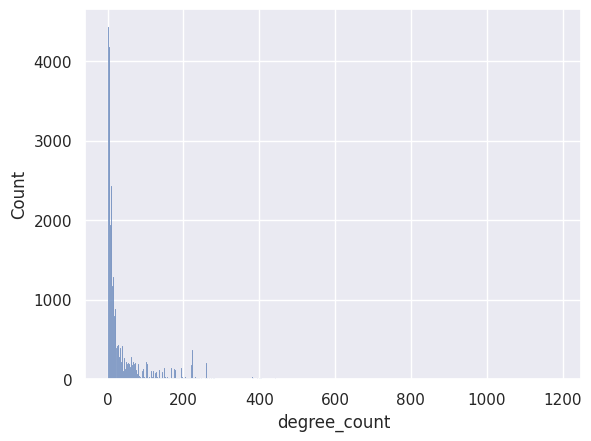

In [122]:
sns.histplot(data['degree_count'])

#### Dropping the outliers (colabs > 1000)

As we can see above there collaborators who are much higher than the collaborations, and much of them are bot's accounts (e.g *houndci* and *nrel-bot*). For this, we're removing them for the analysis.

In [123]:
selRows = data[data['colabs'] > 400].index
data = data.drop(selRows,axis=0)

### Normalizing focus

After removing the outliers we need to normalize the focus metric to properly give insights about the data.

In [124]:
x = data['focus']
x_norm = (x-np.min(x))/(np.max(x)-np.min(x)) + 1e-10 #For log issues in the next cells
data['focus'] = x_norm

In [125]:
data['degree'].describe().to_frame()

,degree
count,27095.000000
mean,0.001599
std,0.002706
min,0.000037
25%,0.000184
50%,0.000442
75%,0.001584
max,0.026700


In [126]:
data['focus'].describe().to_frame()

,focus
count,2.709500e+04
mean,3.745277e-02
std,8.223094e-02
min,1.000000e-10
25%,2.435099e-03
50%,1.008827e-02
75%,3.304777e-02
max,1.000000e+00


### Regression 

<AxesSubplot: xlabel='focus', ylabel='Count'>

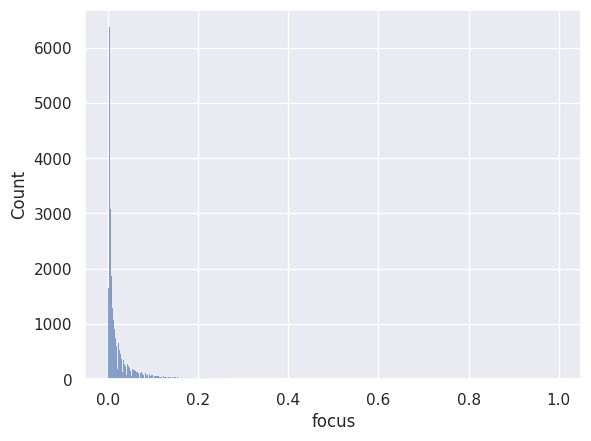

In [127]:
sns.histplot(data['focus'])

<AxesSubplot: xlabel='degree', ylabel='Count'>

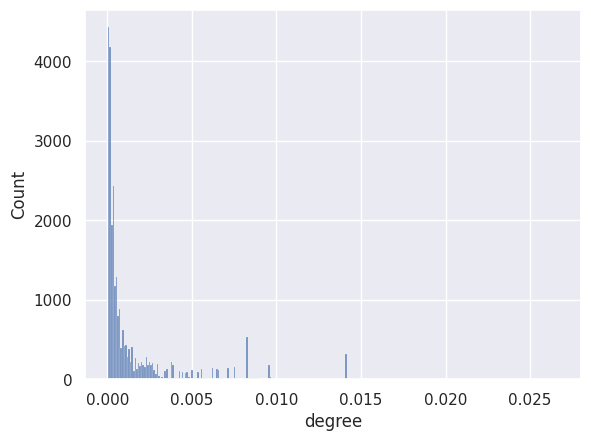

In [128]:
sns.histplot(data['degree'])

In [129]:
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

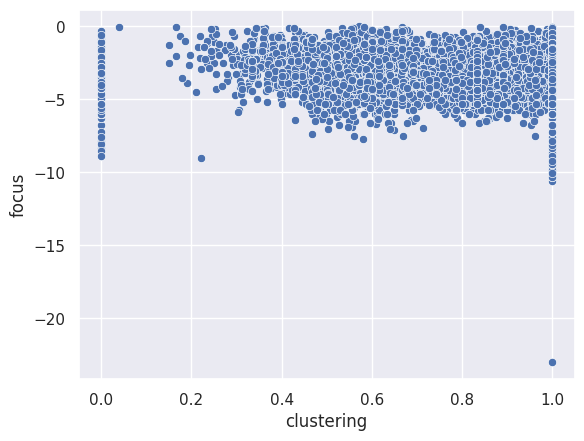

In [130]:
sns.scatterplot(x=data['clustering'], y=np.log(data['focus']));

In [131]:
data.sort_values(by="focus",ascending=False)

,focus,colabs,clustering,degree,degree_count
id,,,,,
Zolmeister,1.000000e+00,396,0.571429,0.000295,8
nursix,9.929958e-01,400,1.000000,0.000258,7
yishaigalatzer,9.769385e-01,383,1.000000,0.002615,71
tde-banana-odoo,9.667342e-01,379,0.891150,0.003830,104
Neamar,9.590811e-01,376,0.666667,0.000221,6
...,...,...,...,...,...
pexcn,3.410513e-05,1,1.000000,0.005008,136
davidvossel,3.410513e-05,1,1.000000,0.000331,9
demobox,3.410513e-05,1,1.000000,0.000552,15


### Residuals

In [132]:
result = reg.linear(data=data, formula='focus ~ clustering')

In [133]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  focus   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     612.0
Date:                Thu, 08 Jun 2023   Prob (F-statistic):          1.26e-133
Time:                        19:06:25   Log-Likelihood:                 29546.
No. Observations:               27095   AIC:                        -5.909e+04
Df Residuals:                   27093   BIC:                        -5.907e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0841      0.002     43.150      0.000       0.080       0.088
clustering    -0.0512      0.002    -24.738      0.000      -0.055      -0.047
==============================================================================
Omnibus:                    27442.379   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1503297.735
Skew:                           5.118   Prob(JB):                         0.00
Kurtosis:                      38.026   Cond. No.                         7.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.051234,0.002071,0.000000


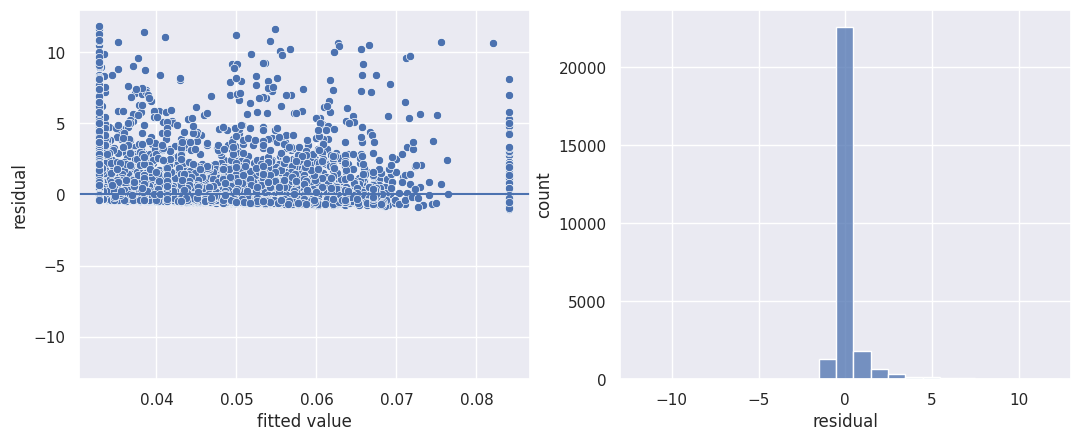

In [135]:
result.plot_residuals()

#### "Massaging" the data

As we can see, the distribution of residuals is not good as we want, because the residuals has not a randomic and normal distribution to give the give the necessary confidence to the model. 

Because of this, we can apply a logaritmic scale to the focus to get a better shape and use the degree as control variable (which means the quantity of neighbors of the vertex).

In [136]:
result = reg.linear(data=data, formula='np.log(focus) ~ clustering + degree')

In [137]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(focus)   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     1044.
Date:                Thu, 08 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:06:26   Log-Likelihood:                -49196.
No. Observations:               27095   AIC:                         9.840e+04
Df Residuals:                   27092   BIC:                         9.842e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0448      0.036    -84.873      0.000      -3.115      -2.975
clustering    -1.6768      0.038    -44.248      0.000      -1.751      -1.603
degree        43.3565      3.341     12.978      0.000      36.808      49.905
==============================================================================
Omnibus:                      495.671   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              706.270
Skew:                           0.219   Prob(JB):                    4.32e-154
Kurtosis:                       3.659   Cond. No.                         504.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [138]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-1.676815,0.037896,0.000000
degree,43.356492,3.340783,0.000000


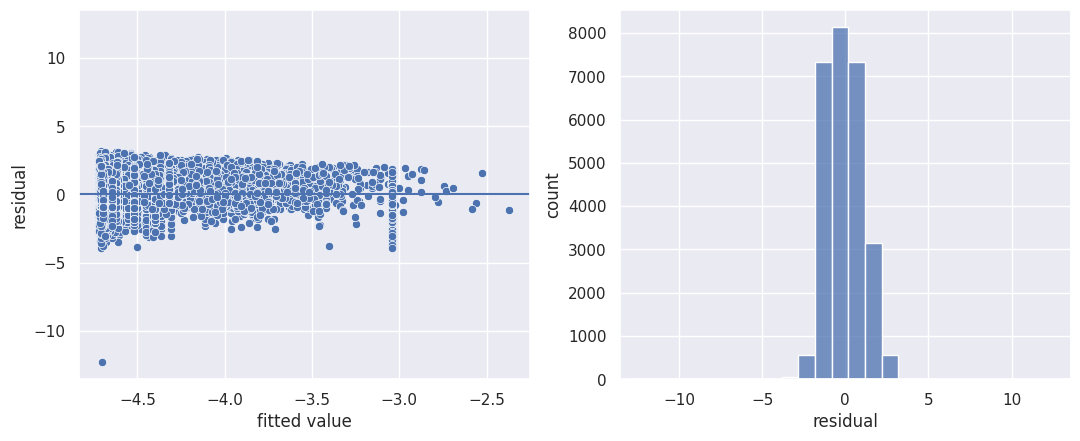

In [139]:
result.plot_residuals()

## Saving the graph

In [140]:
import netpixi

In [141]:
gt_save(g, '../networks/colabs_except_js_python.net.gz')